This notebook replicates key steps of "The Macro-Dynamics of Sorting between Workers and Firms" by Jeremy Lise and Jean-Marc Robin: https://www.aeaweb.org/articles?id=10.1257/aer.20131118

# Model
The economy consists of workers with ability $x \sim Beta(\beta_1,\beta_2)$ and firms with productivity $y\sim{U}(y)$, both with a measure of one. The beginning of period mass of employed and unemployed workers, $h_t(x,y)$ and $u_t(x)$, are such that $u_t(x) + \int h_t(x,y)\,dy=l(x)$. 

An aggregate shock, $z$, which follows a Markov chain with transition probability $\pi(z,z')$, hits the economy and might result in the termination of a job. The post-shock measure are $h_{t+}(x,y)$ and $u_{t+}(x)$. 

It is assumed that workers costlessly search with different intensities: employed workers search with $s$ and unemloyed with $1$. The aggregate effort is $L_t = \int 1\cdot u_{t+}(x)\, dx + \int \int s \cdot h_{t+}(x,y) \, dx \,dy$. Firms post $v_t(y)$ job opportunities for a cost $c(v)$. Aggregate opportunities are $V_t = \int v_t(y)\,dy$. Meetings are assigned randomly with meeting technology $M_t=M(L_t, V_t)=\min \Big( \alpha L_t^\omega V_t^{1-\omega}, L_t, V_t \Big)$. The meeting probabilities for an unemployed and an employed worker are $\lambda_t=\frac{M_t}{L_t}$ and $s\lambda_t$. The meeting probabiliby per posted opportunity is $q_t=\frac{M_t}{V_t}$.

The joint value of a match, $P_t(x,y)$, is the value of a match and includes continuation values of the worker and the firm. The value of being unemployed is $B_{t}(x)$. A match is dissolved if $\mathbb{1}\Big(P_{t+1}(x,y)<B_{t+1}(x)\Big) + \delta \cdot \mathbb{1}\Big(P_{t+1}(x,y) \geq B_{t+1}(x)\Big)$, where $\delta$ is the exogenous separation rate.

The unemployed worker engages in home production $b(x,z_t)$ and values being unemployed:
$$B_t(x) = b(x,z_t) + \frac{1}{1+r} \mathbb{E}_t B_{t+1}(x)$$
Let $S_t(x,y) = P_t(x,y) - B_t(x)$ be the match surplus, then proposition 1 defines the equilibrium to be such that:

$$S(x,y,z) = s(x,y,z) + \frac{1-\delta}{1+r} \int S(x,y,z')^+ \pi(z,z') \, dz'$$
where $s(x,y,z) = p(x,y,z) - b(x,z)$ and $x^+ = \max\Big(x,0\Big)$.



# Implementation

## Definitions

In [18]:
using Parameters
using Distributions
using Plots; pyplot()

include("utils.txt");

In [2]:
?LiseRobinModel

search:



This type stores the parameters of the economy and some technical parameters.

##### Fields

  * `β1::Float64`: Coefficient of Beta distribution of worker types
  * `β2::Float64`: Coefficient of Beta distribution of worker types
  * `c0::Float64`: Scale of cost opportunity posting function
  * `c1::Float64`: Exponent on v of cost opportunity posting function
  * `α::Float64`: Scale of meeting function
  * `ω::Float64`: Exponent on L of meeting function
  * `r::Float64`: Interest rate
  * `δ::Float64`: Exogenous match distruction rate
  * `f0::Float64`: Price scale (used for GDP scaling)
  * `p1::Float64`: Constant in production function
  * `p2::Float64`: Coefficient in production function
  * `p3::Float64`: Coefficient in production function
  * `p4::Float64`: Coefficient in production function
  * `p5::Float64`: Coefficient in production function
  * `p6::Float64`: Coefficient in production function
  * `σ::Float64`: Volatility of z
  * `ρ::Float64`: AR of z
  * `s::Float64`: Search intensity of employed
  * `dt::Float64`: Length of one time period
  * `ϵ::Float64`: Distance of left/right grid element to boundary
  * `Nx::Int64`: Number of grid points in x
  * `Ny::Int64`: Number of grid points in y
  * `Nz::Int64`: Number of grid points in z
  * `Gridx::Vector{Float64}`: Grid on x
  * `Gridy::Vector{Float64}`: Grid on y
  * `Gridz::Vector{Float64}`: Grid on z
  * `Grida::Vector{Float64}`: Grid on a, the random variable of the copula

```
LiseRobinModel()
```

This is a constructor of a LiseRobinModel with parameters from table 2, unless otherwise specified.


I set the parameters at the levels estimated in the paper.

In [3]:
#model = LiseRobinModel(Nx=151, Ny=151, Nz=151);
#model = LiseRobinModel();
model = LiseRobinModel(Nx=101, Ny=101, Nz=101);

## Solving for S

In [4]:
?solveS

search:



```
solveS(model)
```

This function iterates on equation (3) until convergence. 

##### Returns

  * `S::Array{Float64,3}`: Surplus as a function of x, y, z
  * `B::Array{Float64,1}`: Value of unemploymend as a function of x
  * `P::Array{Float64,3}`: Value of a match as a function of x, y, z
  * `l::Array{Float64,1}`: Worker density as a function of x
  * `p::Array{Float64,3}`: Production as a function of x, y, z
  * `b::Array{Float64,1}`: Home production as a function of x
  * `Speriod::Array{Float64,3}`: Period surplus as a function of x, y, z
  * `Q::Array{Float64,2}`: Transition probabilities from z to z'


In [5]:
@time (S, B, P, l, p, b, Speriod, Q) = solveS(model);

 62.291673 seconds (2.19 M allocations: 40.011 GiB, 36.97% gc time)



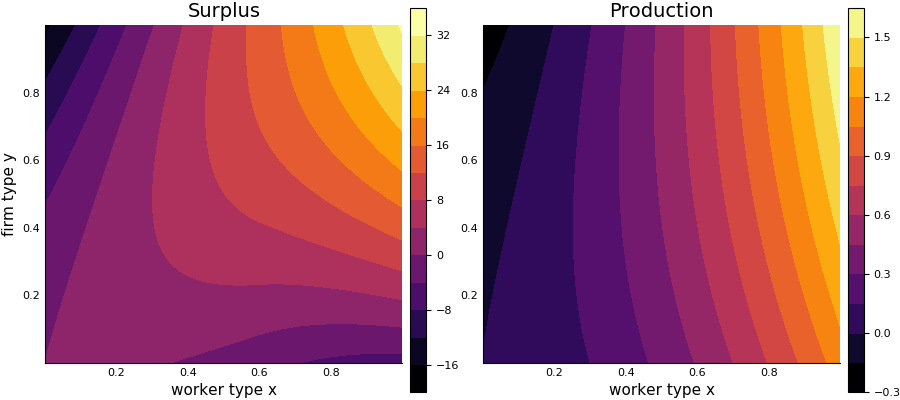

In [6]:
p1 = contour(model.Gridx, model.Gridy, S[:, :, 26]', fill=true, title="Surplus", label="Surplus", ylab="firm type y")
p2 = contour(model.Gridx, model.Gridy, p[:, :, 26]', fill=true, title="Production", label="Production")
plot(p1, p2, size=(900,400), xlab="worker type x")

The stationary distribution of $z$ is:

In [7]:
(D, V) = eig(Q')
index = find((D .≈ 1) .* prod((V ./sum(V, 1)) .>= -1e-8, 1)')[2];


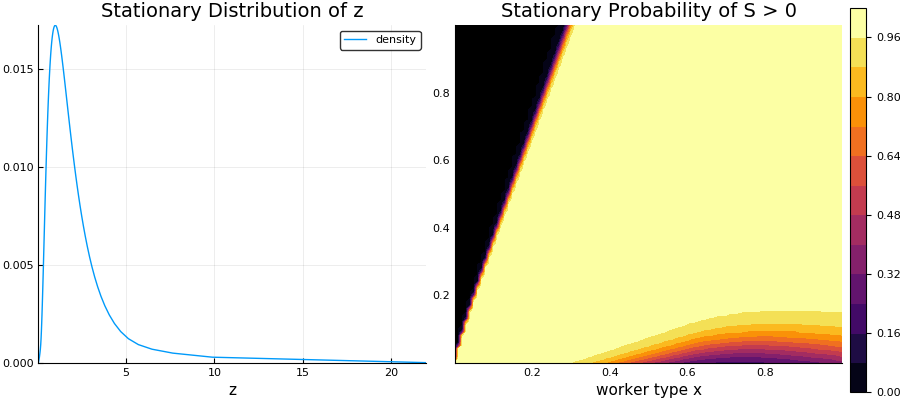

In [8]:
p1 = plot(exp.(model.Gridz), V[:, index]/sum(V[:, index]), title="Stationary Distribution of z", label="density", xlab="z")
p2 = contour(model.Gridx, model.Gridy, 
    (sum(permutedims(S .>= 0, [3, 1, 2]) .* V[:, index]/sum(V[:, index]), 1))[1, :, :]', fill=true, 
    title="Stationary Probability of S > 0", label="S > 0", background_color_inside="black", xlab="worker type x")
plot(p1, p2, size=(900,400))

## Deterministic Steady State for h

In [9]:
?fixedpointh

search:



```
fixedpointh(model, S, l)
```

This function iterates on equation (9) until convergence.

##### Returns

  * `h::Vector{Float64}`: Distribution of employed workers as a function of x, y


In [19]:
@time (h0, w0) = fixedpointh(model, S[:, :, convert(Int,(model.Nz+1)/2)], l);

 34.550991 seconds (17.05 M allocations: 26.513 GiB, 13.32% gc time)


The deterministic steady state distribution of matches is:


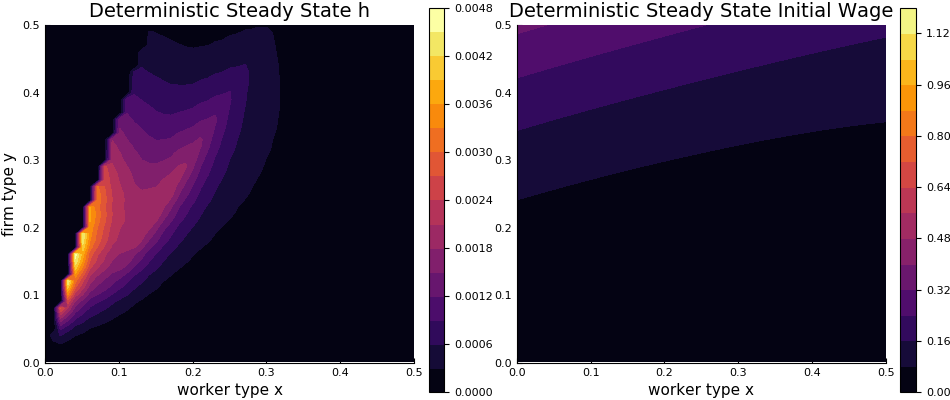

In [20]:
p1 = contour(model.Gridy, model.Gridx, h0'/sum(h0), xlim=[0, 0.5], ylim=[0, 0.5], fill=true, title="Deterministic Steady State h", ylab="firm type y")
p2 = contour(model.Gridy, model.Gridx, w0, xlim=[0, 0.5], ylim=[0, 0.5], fill=true, title="Deterministic Steady State Initial Wage")
plot(p1, p2, xlab="worker type x", size=(950,400))

## Simulation

In [21]:
?simulateh

search:



```
simulateh(model, S, h0, Q)
```

This function simulates 600 years and estimates stationary distributions and flow masses.

##### Returns

(sim_h, sim_J2J, sim_E2U, sim_HfU, sim_HfE)

  * `sim_h::Array{Float64,2}`: Distribution of employed workers as a function of x, y
  * `sim_J2J::Array{Float64,2}`: Flow mass of job-to-job transitions as a function of x, y
  * `sim_E2U::Array{Float64,2}`: Flow mass of unemployed-to-employment transitions as a function of x, y
  * `sim_HfU::Array{Float64,2}`: Flow mass of hires from unemployment as a function of x, y
  * `sim_HfE::Array{Float64,2}`: Flow mass of poached hires as a function of x, y


A run with $Nx=Ny=Nz=101$ should take 15 minutes or shorter:

In [22]:
@time (ts_z, sim_h, sim_J2J, sim_E2U, sim_HfU, sim_HfE) = simulateh(model, S, h0, Q);

815.379538 seconds (131.59 M allocations: 1.167 TiB, 28.27% gc time)



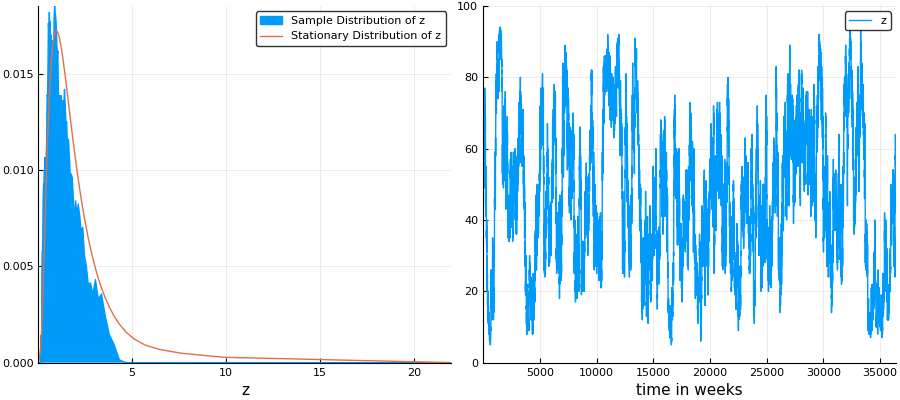

In [47]:
sampledensity = [count(model.Gridz[ts_z] .== model.Gridz[z]) for z in 1:model.Nz]/length(ts_z)
p1 = plot(exp.(model.Gridz), sampledensity, label="Sample Distribution of z", xlab="z", fill=true)
p1 = plot!(exp.(model.Gridz), V[:, index]/sum(V[:, index]), title="", label="Stationary Distribution of z", xlab="z")
p2 = plot(ts_z, ylim=[0, 100], t=[:line :histogram], label="z", xlab="time in weeks")
plot(p1, p2, size=(900,400))


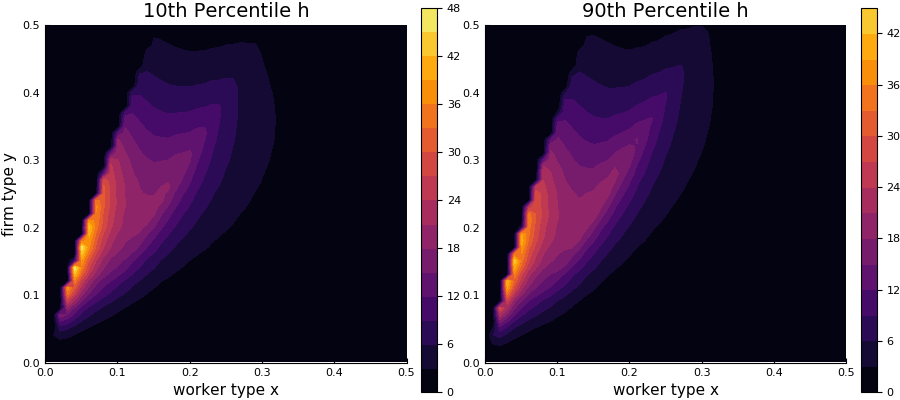

In [71]:
p1 = contour(model.Gridy, model.Gridx, sim_h[:, :, minimum(find(cumsum(sampledensity) .>= 0.1))]', xlim=[0, 0.5], ylim=[0, 0.5], fill=true, ylab="firm type y", title="10th Percentile h", clims=(0, 50))
p2 = contour(model.Gridy, model.Gridx, sim_h[:, :, minimum(find(cumsum(sampledensity) .>= 0.8))]', xlim=[0, 0.5], ylim=[0, 0.5], fill=true, title="90th Percentile h", clims=(0, 50))
plot(p1, p2, size=(900,400), xlab="worker type x")

There is more mass on the border in a recession than in an expansion. Furthermore, the second ridge be seen clearly.